# 📒 RNN & LSTM Deep Dive in PyTorch

---

## 1️⃣ What is an RNN?

**RNN (Recurrent Neural Network)** is a neural network designed to handle **sequential data**.  
It keeps a *hidden state* that gets updated step-by-step, allowing the model to "remember" previous inputs.

### Key Points:
- **Input**: Sequences (e.g., `[x₁, x₂, ..., xₙ]`)
- **Output**: Can be a sequence or a single value
- **Strength**: Handles variable-length sequences
- **Weakness**: Struggles with *long-term dependencies* due to the **vanishing gradient problem**.

---

## 2️⃣ The Vanishing Gradient Problem

- When sequences are long, the gradient (error signal during backpropagation) becomes extremely small.
- This causes early time steps to have almost no influence on learning.
- Solution: **LSTMs** and **GRUs**.

---

## 3️⃣ LSTM (Long Short-Term Memory)

An LSTM is a special type of RNN that solves the vanishing gradient problem by introducing **gates**.

### Gates in LSTM:
1. **Forget Gate**: Decides what to discard from the cell state.
2. **Input Gate**: Decides what new info to store.
3. **Output Gate**: Decides what to output.

📌 **Why LSTM works better**:
- Keeps important info for *long time steps*.
- Learns what to forget and what to remember.

---

## 4️⃣ GRU (Gated Recurrent Unit)

- A simpler LSTM variant.
- Combines the **forget** and **input** gates into a single **update gate**.
- Usually trains faster with similar performance.

---

## 5️⃣ Types of RNN Architectures

1. **Many-to-One**
   - Sequence → Single output
   - Example: Sentiment Analysis

2. **One-to-Many**
   - Single input → Sequence
   - Example: Music generation

3. **Many-to-Many**
   - Sequence → Sequence
   - Example: Machine Translation

4. **Bidirectional RNN/LSTM**
   - Reads sequence forwards & backwards
   - Captures both past and future context

---

## 6️⃣ Important PyTorch Functions for RNN/LSTM

| Function | Purpose | Example |
|----------|---------|---------|
| `np.array()` | Create NumPy arrays | `np.array([1,2,3])` |
| `torch.FloatTensor()` | Create PyTorch tensors | `torch.FloatTensor([[1,2],[3,4]])` |
| `nn.RNN()` | Basic RNN layer | `nn.RNN(input_size, hidden_size)` |
| `nn.LSTM()` | LSTM layer | `nn.LSTM(input_size, hidden_size)` |
| `nn.GRU()` | GRU layer | `nn.GRU(input_size, hidden_size)` |
| `torch.cat()` | Concatenate tensors | `torch.cat((a, b), dim=1)` |
| `unsqueeze()` | Add new dimension | `x.unsqueeze(0)` |

---



# Cross-Domain Predictive Maintenance with LSTM

This notebook demonstrates a simple LSTM model for handling time series data such as vibrations in machines.  
We will walk through why LSTMs are effective for such tasks, the math behind them, and then implement a working model.

---

## 📌 Why LSTM over CNN for Time Series?
* Traditional CNNs are great at spatial feature extraction (e.g., images), but **time-series** like vibrations require capturing dependencies over time.
* CNNs alone can't remember long-term patterns because they operate on fixed windows without state memory.

---

## 🧠 RNN / LSTM Module

### Why not simple RNN?
* **Vanishing Gradient Problem**: In RNNs, if you want to access data from 100+ steps back, the repeated multiplication of weights causes gradients to vanish.
* This leads to the network "forgetting" long-term dependencies.

### How LSTM fixes this:
LSTM uses **memory cells** and **gates** to control what to remember and what to forget.

#### Key equations:
- 1. Forget gate : $ f_t = \sigma(W_f \cdot [h_{t-1}, x_t] + b_f) $ , it gives value between zero and one , that tells old memory how much you can forget or in easy way -: how much to frop the previous information

- 2.  Input gate - $ i_t = \sigma(W_i \cdot [h_{t-1}, x_t] + b_i) $ . it takes decision for adding new information

- 3.  Cell state update : $ C_t = f_t \cdot C_{t-1} + i_t \cdot \tanh(W_C \cdot [h_{t-1}, x_t] + b_C) $  , this helps to maintain long -term memory , where tanh normalize data in range  (-1 to 1 ) 

- 4.  Output gate : $ o_t = \sigma(W_o \cdot [h_{t-1}, x_t] + b_o) $ , it tells $ h_t = o_t \cdot \tanh(C_t) $ for current hidden state h1  , stabilize gradient flow so that it can learn 100+ step data 


* Traditional LSTMs focus on single-task , but we will make it multi-task learning (Ttf prediction + anomaly detection ) and will enhance using attention mechanis, by the way ths is unique in research 

* CD-PM Correction : our CD-PM project works on vibration time - series , by LSTM we can detect long-term degardation pattern (e.g., bearing failure ) , that will increase TtF accuracy .





In [1]:
%pip install torch numpy matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Epoch 0, Loss: 0.0237
Epoch 10, Loss: 0.0128
Epoch 20, Loss: 0.0120
Epoch 30, Loss: 0.0088
Epoch 40, Loss: 0.0159
Epoch 50, Loss: 0.0080
NRMSE: 0.4107
R² Score: -1.8155


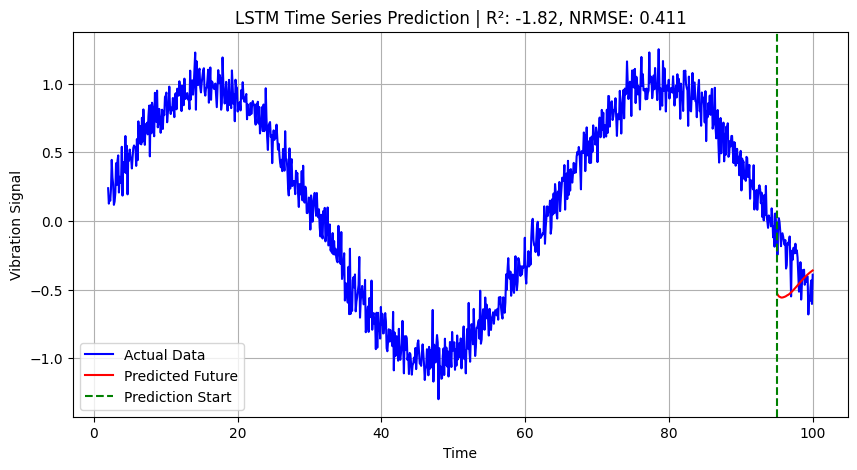

In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# ===================== CONFIGURATION =====================
# LSTM Hyperparameters
seq_length = 20       # Number of time steps the model sees before predicting the next
input_size = 1        # We have 1 feature per time step (the vibration signal value)
hidden_size = 30      # Number of hidden units in LSTM cell
output_size = 1       # Model predicts a single value in the future
batch_size = 32       # Number of sequences per training batch
epochs = 60           # Number of training iterations over the dataset
lr = 0.01             # Learning rate for optimizer

# ===================== DATA GENERATION =====================
# Create synthetic time-series data to simulate vibration patterns with noise
t = np.linspace(0, 100, 1000)  # Time axis
data = np.sin(0.1 * t) + np.random.normal(0, 0.1, 1000)  # Noisy sine wave
data = data.reshape(-1, 1)  # Reshape to column vector

# ===================== CREATE SEQUENCES =====================
# Convert raw data into sequences of length `seq_length` with a corresponding target value
X, y = [], []
for i in range(len(data) - seq_length):
    X.append(data[i:i + seq_length])      # Past seq_length values
    y.append(data[i + seq_length])        # The next value to predict

# Convert lists to tensors
X = torch.FloatTensor(np.array(X))
y = torch.FloatTensor(np.array(y))

# Wrap in Dataset + DataLoader for mini-batch training
dataset = torch.utils.data.TensorDataset(X, y)
loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

# ===================== MODEL DEFINITION =====================
class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initial hidden and cell states set to zeros
        h0 = torch.zeros(1, x.size(0), hidden_size)
        c0 = torch.zeros(1, x.size(0), hidden_size)

        # LSTM output: out -> (batch_size, seq_length, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # Only take the last time step's output for prediction
        out = self.fc(out[:, -1, :])
        return out

# ===================== TRAINING =====================
model = SimpleLSTM(input_size, hidden_size, output_size)
criterion = nn.MSELoss()  # Mean Squared Error for regression
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for epoch in range(epochs):
    for x_batch, y_batch in loader:
        optimizer.zero_grad()
        y_pred = model(x_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ===================== INFERENCE =====================
model.eval()
with torch.no_grad():
    test_input = X[-1].unsqueeze(0)  # Last known sequence
    predicted = []
    for _ in range(50):  # Predict 50 future steps
        next_pred = model(test_input)
        predicted.append(next_pred.item())
        # Append prediction to sequence and drop the oldest value
        next_pred_expanded = next_pred.unsqueeze(2)
        test_input = torch.cat((test_input[:, 1:, :], next_pred_expanded), dim=1)

# ===================== METRICS =====================
actual_future = data[len(data) - 50:].flatten()
predicted_arr = np.array(predicted)

# Normalized RMSE
rmse = np.sqrt(np.mean((predicted_arr - actual_future) ** 2))
nrmse = rmse / (actual_future.max() - actual_future.min())

# R² Score
ss_res = np.sum((actual_future - predicted_arr) ** 2)
ss_tot = np.sum((actual_future - np.mean(actual_future)) ** 2)
r2_score = 1 - (ss_res / ss_tot)

print(f"NRMSE: {nrmse:.4f}")
print(f"R² Score: {r2_score:.4f}")

# ===================== VISUALIZATION =====================
plt.figure(figsize=(10, 5))
plt.plot(t[seq_length:], data[seq_length:], label='Actual Data', color='blue')
plt.plot(
    np.arange(t[-50], t[-50] + 50 * (t[1] - t[0]), t[1] - t[0]),
    predicted, label='Predicted Future', color='red'
)
plt.axvline(x=t[-50], color='green', linestyle='--', label='Prediction Start')
plt.title(f"LSTM Time Series Prediction | R²: {r2_score:.2f}, NRMSE: {nrmse:.3f}")
plt.xlabel("Time")
plt.ylabel("Vibration Signal")
plt.legend()
plt.grid(True)
plt.show()
